#### Sideloading data

In this notebook we'll learn how to add data from sources other than the automated ones into pyWaPOR. We start by creating NDVI, Albedo and LST maps from a manually downloaded Landsat tile and then continue to incorporate that data into `pre_et_look`.

##### Landsat

First we install pywapor, in case it's not installed yet.

In [ ]:
!pip install pywapor==2.4.1 --quiet

Then we'll define the usual parameters.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
startdate = "2021-07-01"
enddate = "2021-07-11"

The function that transforms Landsat Collection-2 Level-2 scenes into `ndvi`, `r0` and `lst` maps, takes one mandatory input variable, which describes in which folder it should look for `tar`-files containing Landsat scenes. So let's start by defining that variable. Note that this folder can be inside your `project_folder`, but doesn't have to be.

In [2]:
landsat_folder = r"/Users/hmcoerver/pywapor_notebooks/my_landsat_folder"

For now the folder is empty (and perhaps doesn't even exist yet). Normally, you would put the files you've downloaded from for example the (Earth Explorer)[https://earthexplorer.usgs.gov] in this folder. But for this notebook we'll use an (much smaller) example file, that we can download like this.

In [3]:
test_file = pywapor.collect.Landsat.C2L2SP.dl_landsat_test(landsat_folder)

100%|██████████| 27.6M/27.6M [00:00<00:00, 89.8MBytes/s]


We can check the contents of our `landsat_folder` like this.

In [4]:
!ls $landsat_folder

LE07_L2SP_177040_20210707_20210802_02_T1.tar


Now that we have our Landsat scene, we can convert it into `ndvi`, `r0` and `lst` maps. 

Besides the path to our `landsat_folder` we will also pass a bounding-box parameter to `pywapor.collect.Landsat.C2L2SP.main`, which will reproject the data to `epsg:4326` and clip the scene to our AOI.

In [5]:
all_files = pywapor.collect.Landsat.C2L2SP.main(landsat_folder, bb = (latlim, lonlim))

No scale/offset found for /Users/hmcoerver/pywapor_notebooks/my_landsat_folder/LE07_L2SP_177040_20210707_20210802_02_T1/LE07_L2SP_177040_20210707_20210802_02_T1_ST_QA.TIF, setting to 1 and 0.


the output, `all_files`, contains three lists, with the paths to any tif-files that have been created.

In [6]:
all_files

(['/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/ndvi/ndvi_LS7_-_-_2021.07.07.07.33.tif'],
 ['/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/r0/r0_LS7_-_-_2021.07.07.07.33.tif'],
 ['/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/lst/lst_LS7_K_-_2021.07.07.07.33.tif'])

Let's have a quick look at them before we continue.

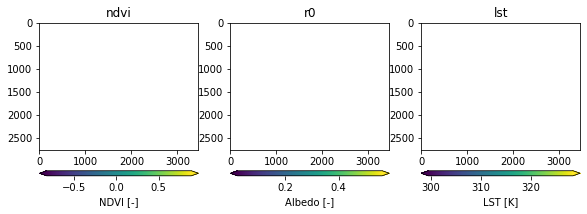

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

ndvi_data = pywapor.general.processing_functions.open_as_array(all_files[0][0])
r0_data = pywapor.general.processing_functions.open_as_array(all_files[1][0])
lst_data = pywapor.general.processing_functions.open_as_array(all_files[2][0])

fig = plt.figure(1)
fig.clf()
fig.set_size_inches(9.69, 5.27)
axs = fig.subplots(1, 3, sharex=False, sharey=False).flatten()

pywapor.post_et_look.plot_img(axs[0], ndvi_data, "ndvi", "NDVI [-]")
pywapor.post_et_look.plot_img(axs[1], r0_data, "r0", "Albedo [-]")
pywapor.post_et_look.plot_img(axs[2], lst_data, "lst", "LST [K]")

That doesn't look good, does it? Landsat 7 has some scanline problems, as a result of which many scenes have stripes of missing data. Because we are zoomed out quite far in these plots, it looks as if there is no data at all. Lets zoom in a little.

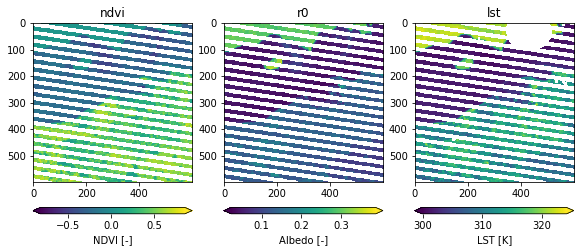

In [9]:
fig = plt.figure(2)
fig.clf()
fig.set_size_inches(9.69, 5.27)
axs = fig.subplots(1, 3, sharex=False, sharey=False).flatten()

xslice = slice(600, 1200)
yslice = slice(1300, 1900)

pywapor.post_et_look.plot_img(axs[0], ndvi_data[xslice, yslice], "ndvi", "NDVI [-]")
pywapor.post_et_look.plot_img(axs[1], r0_data[xslice, yslice], "r0", "Albedo [-]")
pywapor.post_et_look.plot_img(axs[2], lst_data[xslice, yslice], "lst", "LST [K]")

Now you can see that there actually is data. 

Also notice the circle of missing data in the lst-map. Each level-2 Landsat scene comes with a map indicating the uncertainty in the given lst-values. By default, `pywapor.collect.Landsat.C2L2SP.main` automatically masks out any `lst` values that have an uncertainty greater than 2.5 K. You can adjust this value by passing the keyword argument `max_lst_uncertainty` to the function. For example like this: `all_files = pywapor.collect.Landsat.C2L2SP.main(landsat_folder, max_lst_uncertainty = 5.0)`.

We can check our Landsat folder again.

In [10]:
%ls $landsat_folder

LE07_L2SP_177040_20210707_20210802_02_T1.tar
lst/
ndvi/
r0/


As you can see, there are now three folders next to our tar-file, which contain the maps that have been created.

##### Sideloading

Now that we have some data that we would like to include in `pre_et_look`, we can define a custom level like we've done in the previous notebook.

In [12]:
my_custom_level = {
        # Main inputs
        "ndvi":         ["LS7"],
        "r0":           ["LS7"],
        "lst":          ["LS7"],
        "lulc":         ["WAPOR"],
        "z":            ["SRTM"],
        "p_24":         ["CHIRPS"],
        "ra_24":        ["MERRA2"],

        # Daily meteo 
        't_air_24':     ["GEOS5"],
        't_air_min_24': ["GEOS5"], 
        't_air_max_24': ["GEOS5"],
        'u2m_24':       ["GEOS5"],
        'v2m_24':       ["GEOS5"],
        'p_air_0_24':   ["GEOS5"],
        'qv_24':        ["GEOS5"],

        # Instanteneous meteo
        "t_air_i":      ["GEOS5"],
        "u2m_i":        ["GEOS5"],
        "v2m_i":        ["GEOS5"],
        "qv_i":         ["GEOS5"],
        "wv_i":         ["GEOS5"],
        "p_air_i":      ["GEOS5"],
        "p_air_0_i":    ["GEOS5"],

        # Temporal constants
        "lw_offset":    ["STATICS"],
        "lw_slope":     ["STATICS"],
        "r0_bare":      ["STATICS"],
        "r0_full":      ["STATICS"],
        "rn_offset":    ["STATICS"],
        "rn_slope":     ["STATICS"],
        "t_amp_year":   ["STATICS"],
        "t_opt":        ["STATICS"],
        "vpd_slope":    ["STATICS"],
        "z_oro":        ["STATICS"],

        # Level name
        "level_name": "sideloading_level",
}

What's different from the previous notebook however, is that now we also need to tell `pre_et_look` where to find these new sources (i.e. `"LS7"`). We do that with another dictionary.

In [13]:
extra_source_locations = {
    ("LS7", "ndvi"): r"/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/ndvi",
    ("LS7", "r0"): r"/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/r0",
    ("LS7", "lst"): r"/Users/hmcoerver/pywapor_notebooks/my_landsat_folder/lst",
}

For each entry of the form "(`source`, `parameter`): `folder_path`", `pre_et_look` will look for files in the folder given by `folder_path` which look like `{parameter}_{source}_*_%Y.%m.%d.%H.%M.tif` and then treat those files a any other source.

So now we can run `pre_et_look`.

In [14]:
ds_in, fh_in = pywapor.pre_et_look.main(project_folder, startdate, enddate, 
    latlim, lonlim, level = my_custom_level, extra_source_locations = extra_source_locations)

> PRE_ET_LOOK
    # ndvi
    --> Collected 1 LS7 file(s).
    --> Resampling resolution is ~30 meter.
    --> Resampling datasets.
    --> Calculating composites.
    # p_24
    --> Downloading CHIRPS.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
    --> Resampling datasets.
    --> Calculating composites.
    # se_root
    > PRE_SE_ROOT
        # ndvi
        --> Collected 1 LS7 file(s).
        --> Resampling resolution is ~30 meter.
        --> Resampling datasets.
        # lst
        --> Collected 1 LS7 file(s).
        --> Resampling datasets.
        > METEO
            # t_air_i
            --> Downloading GEOS5 (3-hourly), t2m.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
            --> Applying 'kelvin_to_celsius' to `t_air_i` from GEOS5.
            # u2m_i
            --> Downloading GEOS5 (3-hourly), u2m.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
            # v2m_i
            --> Downloading GEOS5 (3-hourly), v2m.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
            # qv_i
  